In [1]:
import os
import sys
import importlib
import math
import time

import itertools
from collections import defaultdict

import numpy as np
import pandas as pd
import scipy.stats as ss
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm as tqdm_auto
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import pytorch_lightning as pl

from IPython.display import clear_output
from scipy.stats import spearmanr, pearsonr
from sklearn.metrics import r2_score

In [2]:
import model.utrdata_cl as utrdata
from model.legnet import LegNetClassifier
from model.pl_regressor import RNARegressor

In [3]:
# 查看当前安装的版本
import pytorch_lightning as pl
print(f"PyTorch Lightning版本: {pl.__version__}")
print(f"PyTorch版本: {torch.__version__}")

# 如果版本不兼容，可以尝试降级或升级
# pip install pytorch-lightning==1.9.5 torch==1.13.1

PyTorch Lightning版本: 2.5.0.post0
PyTorch版本: 2.6.0+cu124


## Loading data

In [4]:
# Full code to add fold column
PATH_FROM = "../Data_Processing/vJun26_3UTR_Timo_Matt_Merged_data_mincount100.csv"

# Read the data
df = pd.read_csv(PATH_FROM, index_col = 0)

celltype_codes = list(df["cell_type"].unique())

num_classes = len(celltype_codes)
print('Num Class = ', num_classes)

# # Check the distribution
df_train = df[df['fold'] == 'train']
df_val = df[df['fold'] == 'val']

train_count = len(df_train)
val_count = len(df_val)
print(f"Training samples (fold 0): {train_count} ({train_count/len(df)*100:.2f}%)")
print(f"Validation samples (fold 1): {val_count} ({val_count/len(df)*100:.2f}%)")

# Save the updated dataframe
# df.to_csv(PATH_TO, index=False)

# print(f"Saved dataframe with fold column to: {PATH_TO}")
df

Num Class =  20
Training samples (fold 0): 447897 (92.90%)
Validation samples (fold 1): 34229 (7.10%)


,sequence,center_of_mass,z_score,total_counts,adjusted_z_score,cell_type,ID,fold,mean_center_of_mass,diff,cell_type_code
26928,CGAATTGTAATAAGTGTCCTAAGTAGCAGGACTTAACATAGAAAGA...,2.545337,2.178205,2885.337177,0.462334,A549,TSC22D2_part_21_type_middle_overlap_50,val,2.752998,-0.207661,0
26145,TCAAATGCATTACGCTAAAGGAAAGAACCCAGTCCCAAAAAGTTAC...,2.471913,-1.341167,2850.077752,-0.128891,c6_Rep1,NaN,train,2.552489,-0.080576,1
10787,ATGCCTGCCTATTTGGATGGGTATGTCAAACGCTTTCTTCTGGACA...,2.196962,-8.305841,939.037621,-1.129008,c1_Rep1,NaN,train,2.335757,-0.138795,2
9554,AGATTTTCGTCCTGAAAACTTGGGAGGAGGAATTGTTTGATTCTCC...,3.091018,20.869890,1558.650776,0.992797,c10_Rep1,NaN,train,2.666265,0.424753,3
7106,TGGTTTTTATTTGCAGTTTTTAGTTGCTGTAATTGTTGCTGTTTCC...,2.848042,10.896188,1225.169841,1.022520,c2_Rep2,NaN,train,2.779732,0.068310,4
...,...,...,...,...,...,...,...,...,...,...,...
13410,ATTCTCCAGGTCCAAGGCAGAGATCCTGAAAAGATAGGGCTATTGT...,2.379524,-6.346775,3469.086656,-0.608390,c6_Rep1,NaN,train,2.423649,-0.044125,1
16251,CGGCTGGAAGCAGAGGCCTTCGTAGGTGATGGCCTGCATGTTGTAA...,2.557310,2.701370,2777.289157,0.258354,c6_Rep1,NaN,train,2.542396,0.014913,1
18305,TGTTTTTCTCACTGTGGTGTGATTGGCTAAACAATCTCGCATTAAA...,3.046742,17.155525,1230.703443,2.778007,MP2,PHF6_part_18_type_middle_overlap_50,train,2.751035,0.295707,5
12460,AACTGCAGGGCTGTCAGGAGGATCAGAAATACTGTAACAGACATAA...,2.009885,-23.079223,2771.769401,-2.439837,c2_Rep1,NaN,train,2.088828,-0.078943,10


In [5]:
celltype_codes

['A549',
 'c6_Rep1',
 'c1_Rep1',
 'c10_Rep1',
 'c2_Rep2',
 'MP2',
 'MCF7',
 'c13_Rep2',
 'K562',
 'BxPC3',
 'c2_Rep1',
 'PC3',
 'c17_Rep1',
 'c17_Rep2',
 'c4_Rep2',
 'c13_Rep1',
 'c4_Rep1',
 'c6_Rep2',
 'Colo320',
 'H23']

In [6]:
batch_size = 1024
steps_per_epoch = max(1, df_train.shape[0] // batch_size)

# batch_per_epoch = 128  # None

# if batch_per_epoch is None:
#     # batch_per_epoch = int(np.ceil(splits["train"].shape[0] / batch_size))
#     batch_per_epoch = splits["train"].shape[0] // batch_size  # drop_last=True @ DataLoader

epochs = 20

In [7]:
num_workers = 32

In [8]:
def launch_model(
    seed: int,
    train_ds_kws: dict,
    val_ds_kws: dict,
    model_class,
    model_kws: dict,
    criterion_class,
    criterion_kws: dict,
    optimizer_class,
    optimizer_kws: dict,
    lr_scheduler_class,
    lr_scheduler_kws: dict,
    test_time_validation: bool,
    epochs: int = epochs,
):
    pl.seed_everything(seed)

    # Creating Datasets
    train_set = utrdata.UTRData(
        df=df_train,
        **train_ds_kws,
    )
    val_set = utrdata.UTRData(
        df=df_val,
        **val_ds_kws,
    )

    assert train_set.num_channels == val_set.num_channels
    try:
        div_factor = val_ds_kws["augment_kws"]["shift_left"] + \
                     val_ds_kws["augment_kws"]["shift_right"] + 1
    except KeyError:
        div_factor = 1

    # Creating DataLoaders
    dl_train = DataLoader(
        train_set,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=True,
        drop_last=True
    )
    # dl_train = utrdata.DataLoaderWrapper(dl_train, batch_per_epoch=batch_per_epoch)
    dl_val = DataLoader(
        val_set,
        batch_size=batch_size // div_factor,
        num_workers=num_workers,
        shuffle=False,
        drop_last=False
    )

    model = RNARegressor(
        model_class=model_class,
        model_kws=model_kws | dict(
            in_channels=train_set.num_channels
        ),
        criterion_class=criterion_class,
        criterion_kws=criterion_kws,
        optimizer_class=optimizer_class,
        optimizer_kws=optimizer_kws,
        lr_scheduler_class=lr_scheduler_class,
        lr_scheduler_kws=lr_scheduler_kws,
        test_time_validation=test_time_validation,
    )
    
    checkpoint_callback = pl.callbacks.ModelCheckpoint(
        dirpath="vJun26_3UTR_mincount100_saved_models",
        save_top_k=1,
        save_last=False,
        monitor="val_pearson_r_0",
        mode="max"
    )
    progressbar_callback = pl.callbacks.TQDMProgressBar(refresh_rate=0.5)

    logger = pl.loggers.tensorboard.TensorBoardLogger("tb_logs", name=model.model_name)
    trainer = pl.Trainer(
        callbacks=[checkpoint_callback, progressbar_callback],
        logger=logger,
        accelerator="gpu",
        devices=1,
        deterministic=True,
        max_epochs=epochs,
        num_sanity_val_steps=0,
        # gradient_clip_val=1e-5,
        # gradient_clip_algorithm="norm",
    )
    trainer.fit(model=model, train_dataloaders=dl_train, val_dataloaders=dl_val)
    best_model = RNARegressor.load_from_checkpoint(checkpoint_callback.best_model_path)

    prediction = trainer.predict(model=best_model, dataloaders=dl_val)
    val_pred, val_real = zip(*prediction)
    val_pred = torch.concat(val_pred).numpy()
    val_real = torch.concat(val_real).numpy()
    val_df = df_val.copy()
    val_df["real_0"] = val_real[:, 0]
    val_df["real_1"] = val_real[:, 1]
    val_df["pred_0"] = val_pred[:, 0]
    val_df["pred_1"] = val_pred[:, 1]

    return trainer, val_df

In [9]:
checked = {
    "seed": [3],  # 3, 7, 13, 42, 100
    "features": [
        # ("sequence", "revcomp", "intensity", "positional", "conditions"),
        ("sequence", "positional", "conditions"),
    ],
    "augment_dict": [
        dict(
            extend_left=0,
            extend_right=0,
            shift_left=0,
            shift_right=0,
            revcomp=False,
        ),
    ],
    "epochs": [10],
    # "task_loss": [
    #     ("soft_classification", nn.CrossEntropyLoss),
    #     ("soft_regression", nn.MSELoss),
    #     ("regression", nn.MSELoss),
    # ]
}

for subset in itertools.product(
    *checked.values()
):
    PARAMS = dict(zip(checked.keys(), subset))
    AUGMENT_KEY = any(PARAMS["augment_dict"].values())
    AUGMENT_TEST_TIME = AUGMENT_KEY

    trainer_last, prediction_best_last = launch_model(
        seed=PARAMS["seed"],
        train_ds_kws=dict(
            celltype_codes = celltype_codes,
            predict_cols = ['diff', 'center_of_mass'],
            construct_type="utr5",
            features=PARAMS["features"],  # ("sequence", "conditions", "positional", "revcomp")
            augment=AUGMENT_KEY,
            augment_test_time=False,
            augment_kws=PARAMS["augment_dict"],
        ),
        val_ds_kws=dict(
            celltype_codes = celltype_codes,
            predict_cols = ['diff', 'center_of_mass'],
            construct_type="utr5",
            features=PARAMS["features"],  # ("sequence", "conditions", "positional", "revcomp")
            augment=False,
            augment_test_time=AUGMENT_TEST_TIME,
            augment_kws=PARAMS["augment_dict"],
        ),
        model_class=LegNetClassifier,
        model_kws=dict(
            seqsize=50,
            in_channels=4,  # IS REPLACED
            ks=3,
            out_channels=2,
            conv_sizes=(128, 64, 64, 32, 32),
            mapper_size=256,
            linear_sizes=None,
            use_max_pooling=False,
            final_activation=nn.Identity
        ),
        criterion_class=nn.MSELoss,
        criterion_kws=dict(),
        optimizer_class=torch.optim.AdamW,
        optimizer_kws=dict(
            # lr=0.01,
            weight_decay=0.1,
        ),
        lr_scheduler_class=torch.optim.lr_scheduler.OneCycleLR,
        lr_scheduler_kws=dict(
            max_lr=0.01,
            steps_per_epoch=steps_per_epoch,
            epochs=PARAMS["epochs"],
            pct_start=0.3,
            three_phase=False,
            cycle_momentum=True,
        ),
        test_time_validation=AUGMENT_TEST_TIME,
        epochs=PARAMS["epochs"],
    )

[rank: 0] Seed set to 3
/home/yanyichu/miniconda/envs/py312_evo/lib/python3.12/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 32 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/home/yanyichu/miniconda/envs/py312_evo/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/yanyichu/miniconda/envs/py312_evo/lib/python3. ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CU

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=10` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |                                                                                                 …

In [10]:
AUGMENT_KEY, AUGMENT_TEST_TIME

(False, False)

# Predict

In [11]:
model = RNARegressor.load_from_checkpoint('./vJun26_3UTR_mincount100_saved_models/epoch=9-step=4370.ckpt')
model.eval()

div_factor = 1
val_ds_kws=dict(
            celltype_codes = celltype_codes,
            predict_cols = [],
            construct_type="utr5",
            features=PARAMS["features"],  # ("sequence", "conditions", "positional", "revcomp")
            augment=False,
            augment_test_time=AUGMENT_TEST_TIME,
            augment_kws=PARAMS["augment_dict"],
        )

val_set = utrdata.UTRData(
        df=df_val,
        **val_ds_kws,
    )
dl_val = DataLoader(
    val_set,
    batch_size=batch_size // div_factor,
    num_workers=num_workers,
    shuffle=False,
    drop_last=False
)

trainer = pl.Trainer(accelerator="cpu")
prediction = trainer.predict(model=model, dataloaders=dl_val)
val_pred, val_real = zip(*prediction)
val_pred = torch.concat(val_pred).numpy()
val_real = torch.concat(val_real).numpy()
val_df = df_val.copy()
# val_df["real_diff"] = val_real[:, 0]
# val_df["real_center_of_mass"] = val_real[:, 1]
val_df["pred_diff"] = val_pred[:, 0]
val_df["pred_center_of_mass"] = val_pred[:, 1]

/home/yanyichu/miniconda/envs/py312_evo/lib/python3.12/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 32 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/home/yanyichu/miniconda/envs/py312_evo/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/yanyichu/miniconda/envs/py312_evo/lib/python3. ...
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/yanyichu/miniconda/envs/py312_evo/l

Predicting: |                                                                                                 …

In [12]:
val_df

,sequence,center_of_mass,z_score,total_counts,adjusted_z_score,cell_type,ID,fold,mean_center_of_mass,diff,cell_type_code,pred_diff,pred_center_of_mass
26928,CGAATTGTAATAAGTGTCCTAAGTAGCAGGACTTAACATAGAAAGA...,2.545337,2.178205,2885.337177,0.462334,A549,TSC22D2_part_21_type_middle_overlap_50,val,2.752998,-0.207661,0,-0.098261,2.572512
13190,TATGTGAAACAGCTGGAATTGTACAAATTTTGGTTGTATTTAAAGC...,2.656825,3.847176,752.255275,0.814743,A549,LEMD3_part_12_type_middle_overlap_50,val,2.608619,0.048205,0,-0.000918,2.583666
13414,ACCTGGGAAGGCAGGCCCAGAACCCATTTCCTTGACTTGCAGTTCC...,2.554491,2.370443,2365.512999,0.251698,c2_Rep1,NaN,val,2.542149,0.012342,10,-0.039479,2.573782
5689,GAAGATTTCAAAGTTAATTTTCCCTCCTTATTTTTGAATTGACTGA...,2.254603,-5.371137,598.832954,-1.131736,A549,CSN2_part_1_type_leftmost_overlap_50,val,1.988013,0.266591,0,0.069608,2.233449
17091,GATGAACTTGTTAAATCTTCTCAGTGTCTATTTATCAGCACAATAC...,2.399040,-4.110927,2072.461594,-0.394213,c6_Rep1,NaN,val,2.527900,-0.128861,1,-0.054084,2.385996
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20503,GAGATCCAAAAAAAATGAAAACCTAGGAAAGTAGCAAATATGTGAG...,2.743051,4.741544,475.722416,0.446276,c2_Rep2,NaN,val,2.455669,0.287382,4,-0.039949,2.532078
12042,CTTCTGCTCCAGCTTGCTGGATGTTACCTGTCCTCTTCCCTCCACA...,2.640437,8.955308,5082.824172,0.857434,c6_Rep1,NaN,val,2.601853,0.038585,1,-0.130516,2.407819
13635,CCCTGCGTCCTGACGCCCTGCGTTGGAGCCACTCCTGTCCCGCCTT...,2.427463,-4.757523,5377.203194,-0.456152,c6_Rep1,NaN,val,2.537910,-0.110447,1,-0.161861,2.367719
3692,AAGGAATTGGACCAAATAATTTACCACATAGCTCTAAAACTTAATT...,2.811565,19.248974,4771.195968,1.564437,c17_Rep1,NaN,val,2.768139,0.043426,12,0.116887,2.864465


In [13]:
val_df.sequence[0]

'TGCAGTTTTGACCTCCCAGGCTCAAGCGATCCTCCTGCCTCAGCCTCCCAAGTAGCTGGGAGCCTGGGCATGCATCGCCACGTCTGGCTAATTATTATTTTTTGTAGACAGGGTCTCACTGTGTTGCCCAAGCTTGTCTTGAACTCCTGGCCTTAAGTGATCCTCCCACCTCAGCCTCCTGAGTAGCTGGGACTACAGGCATGAGCCACCATGCCTGGCCAACTCACATTTTTCTTTCTA'

## Launching model

In [14]:
def calculate_metrics(x_data, y_data):
    """计算所有相关性指标"""
    # 移除NaN值
    mask = ~(np.isnan(x_data) | np.isnan(y_data))
    x_clean = x_data[mask]
    y_clean = y_data[mask]
    
    if len(x_clean) == 0:
        return {'r_pearson': np.nan, 'r_spearman': np.nan, 'r2_score': np.nan}
    
    r_pearson = ss.pearsonr(x_clean, y_clean).statistic
    r_spearman = ss.spearmanr(x_clean, y_clean)[0]
    r2 = r2_score(x_clean, y_clean)
    
    return {
        'r_pearson': r_pearson,
        'r_spearman': r_spearman,
        'r2_score': r2
    }

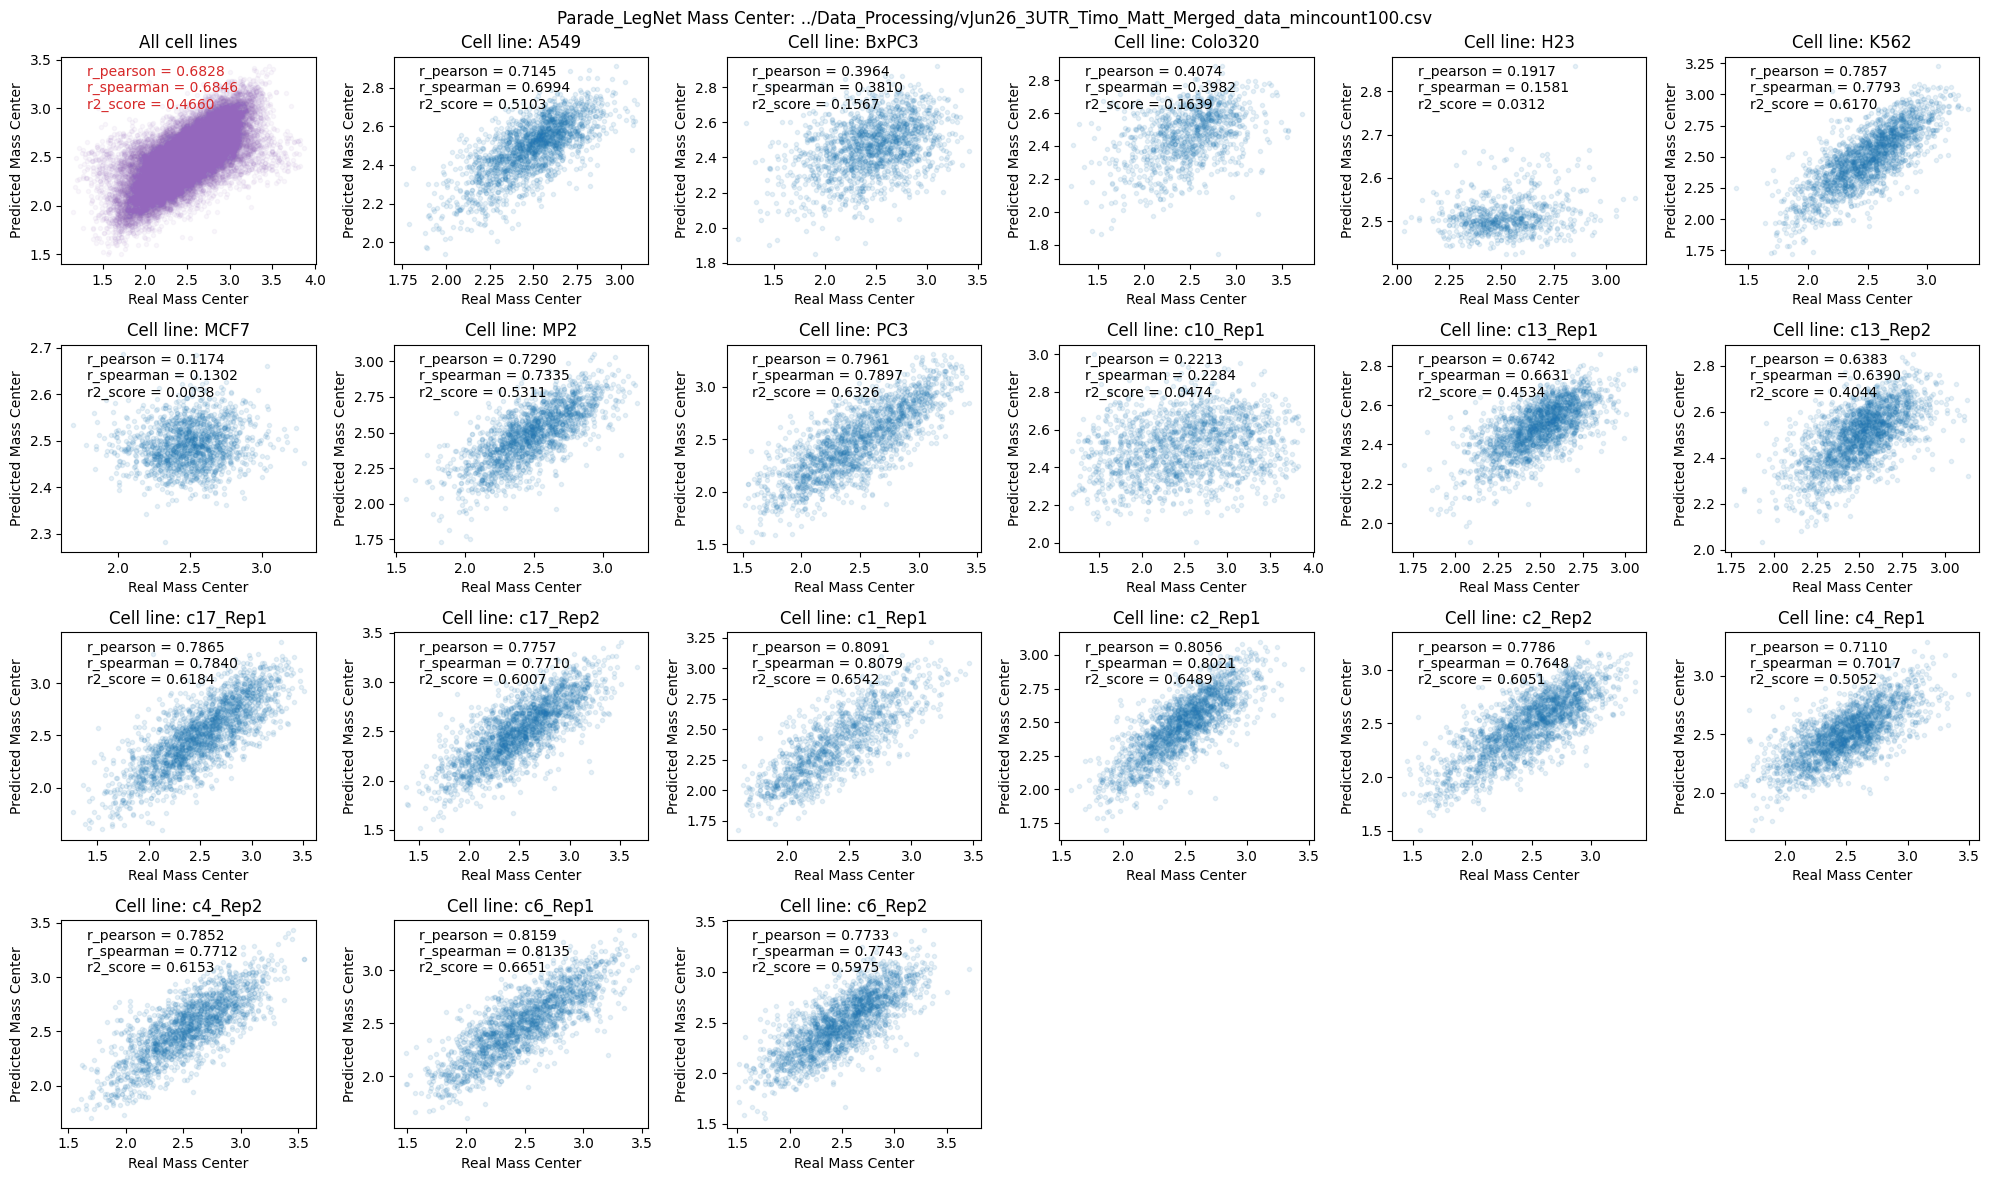

In [15]:
# 初始化metrics DataFrame
metrics_data = []

# 第一个图：Mass Center
plt.figure(figsize=(20, 12))
rows = 4
cols = 6
x = "center_of_mass"  # real_1
y = "pred_1"

# 所有细胞系的图
ax = plt.subplot(rows, cols, 1)
metrics = calculate_metrics(prediction_best_last[x].values, prediction_best_last[y].values)
plt.scatter(prediction_best_last[x], prediction_best_last[y], color="C4", marker=".", alpha=0.05)
plt.text(0.1, 0.75, f"r_pearson = {metrics['r_pearson']:.04f}\n"
                   f"r_spearman = {metrics['r_spearman']:.04f}\n"
                   f"r2_score = {metrics['r2_score']:.04f}", 
         color="C3", transform=ax.transAxes)
plt.title("All cell lines")
plt.ylabel("Predicted Mass Center")
plt.xlabel("Real Mass Center")

# 添加到metrics数据
metrics_data.append({
    'cell_type': 'All',
    'metric_type': 'center_of_mass',
    'r_pearson': metrics['r_pearson'],
    'r_spearman': metrics['r_spearman'],
    'r2_score': metrics['r2_score']
})

# 各个细胞系的图
for i, (ct, ctdf) in enumerate(prediction_best_last.groupby(by="cell_type"), 2):
    metrics = calculate_metrics(ctdf[x].values, ctdf[y].values)
    ax = plt.subplot(rows, cols, i)
    plt.scatter(ctdf[x], ctdf[y], color="C0", marker=".", alpha=0.1)
    plt.text(0.1, 0.75, f"r_pearson = {metrics['r_pearson']:.04f}\n"
                       f"r_spearman = {metrics['r_spearman']:.04f}\n"
                       f"r2_score = {metrics['r2_score']:.04f}", 
             transform=ax.transAxes)
    plt.title(f"Cell line: {ct}")
    ax.set_xlabel("Real Mass Center")
    ax.set_ylabel("Predicted Mass Center")
    
    # 添加到metrics数据
    metrics_data.append({
        'cell_type': ct,
        'metric_type': 'center_of_mass',
        'r_pearson': metrics['r_pearson'],
        'r_spearman': metrics['r_spearman'],
        'r2_score': metrics['r2_score']
    })

plt.tight_layout()
plt.suptitle(f'Parade_LegNet Mass Center: {PATH_FROM}')
plt.tight_layout()
plt.show()

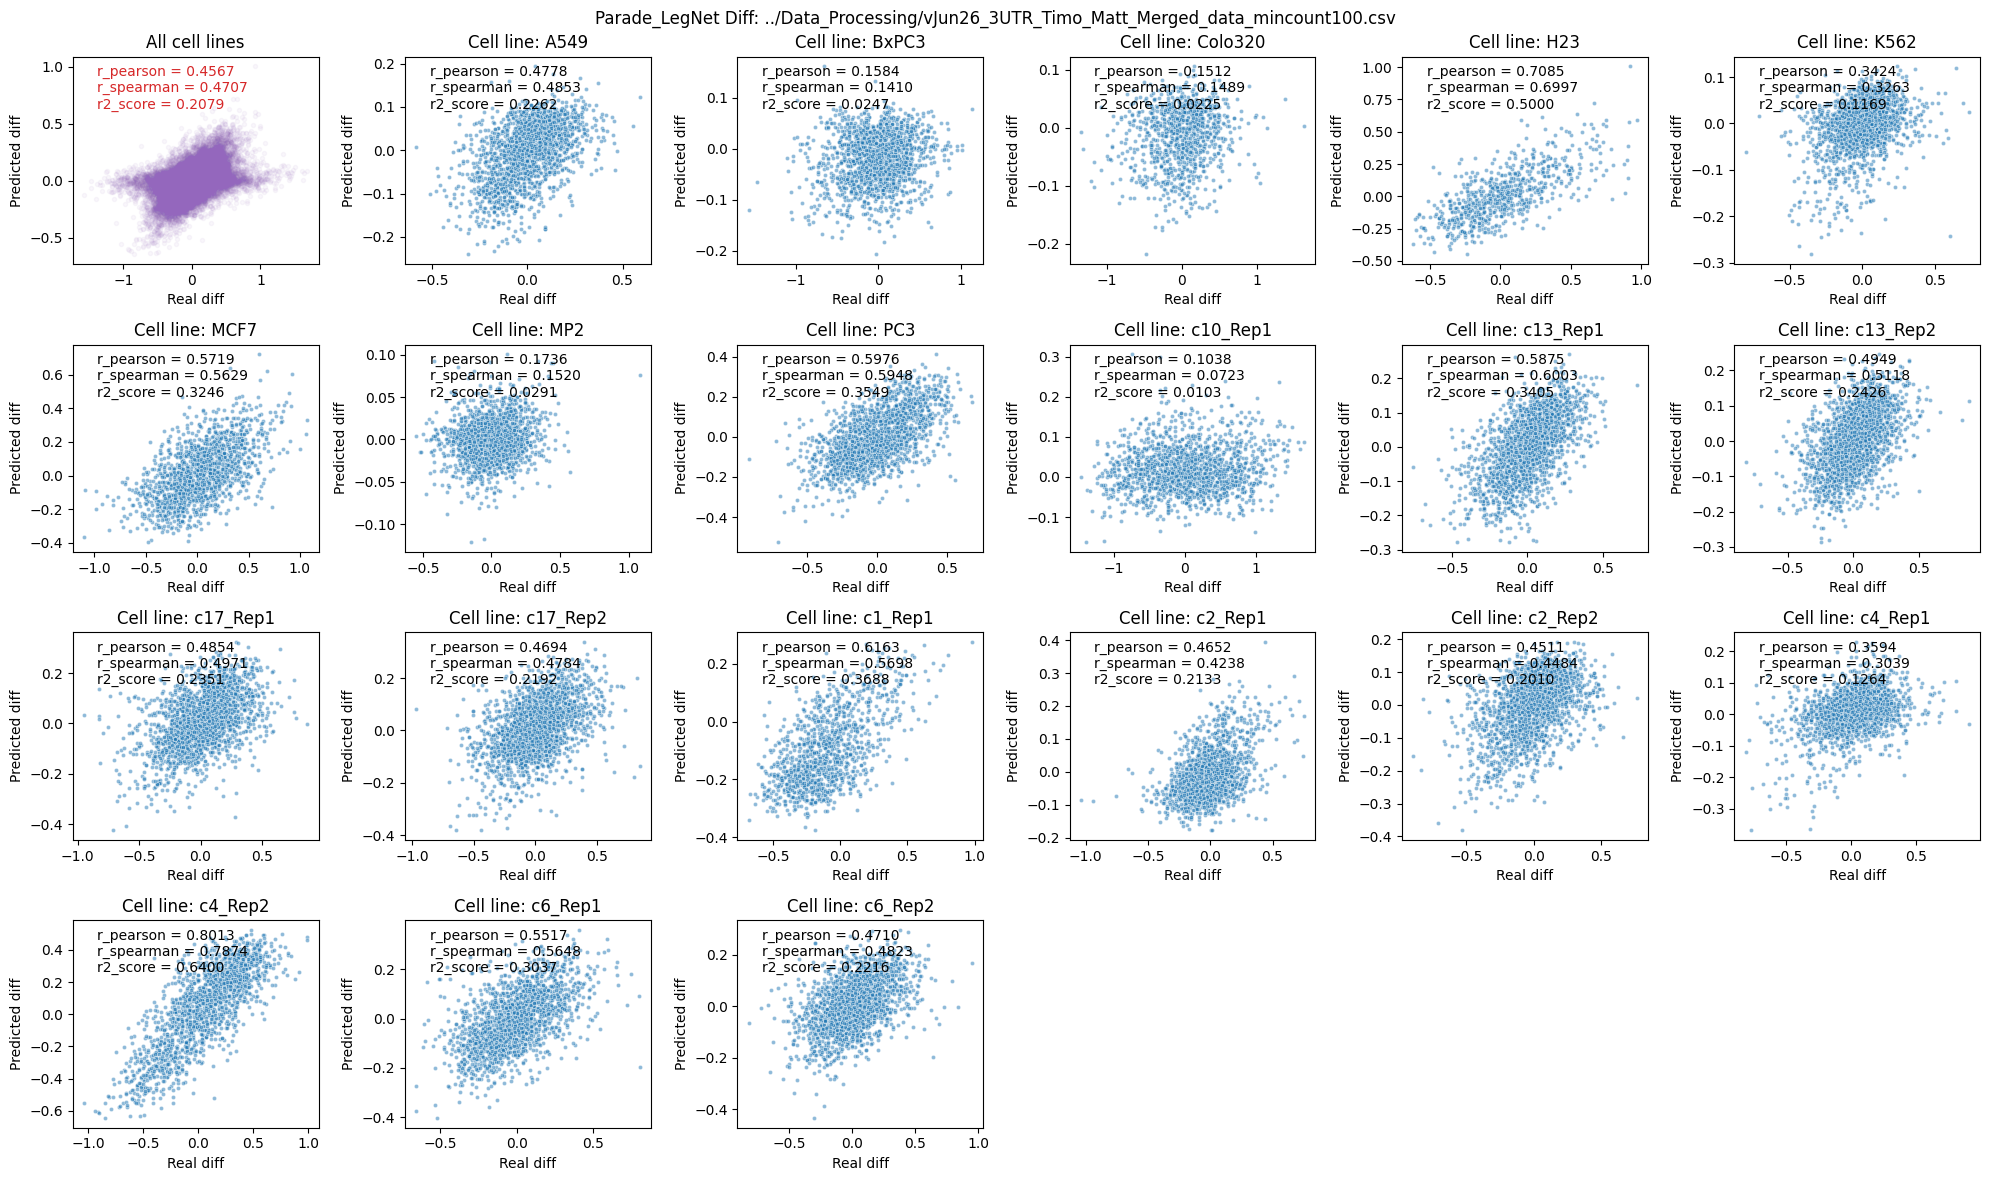

In [16]:
# 第二个图：Diff
plt.figure(figsize=(20, 12))
rows = 4
cols = 6
x = "diff"  # real_0
y = "pred_0"

# 所有细胞系的图
ax = plt.subplot(rows, cols, 1)
metrics = calculate_metrics(prediction_best_last[x].values, prediction_best_last[y].values)
plt.scatter(prediction_best_last[x], prediction_best_last[y], color="C4", marker=".", alpha=0.05)
plt.text(0.1, 0.75, f"r_pearson = {metrics['r_pearson']:.04f}\n"
                   f"r_spearman = {metrics['r_spearman']:.04f}\n"
                   f"r2_score = {metrics['r2_score']:.04f}", 
         color="C3", transform=ax.transAxes)
plt.title("All cell lines")
plt.ylabel("Predicted diff")
plt.xlabel("Real diff")

# 添加到metrics数据
metrics_data.append({
    'cell_type': 'All',
    'metric_type': 'diff',
    'r_pearson': metrics['r_pearson'],
    'r_spearman': metrics['r_spearman'],
    'r2_score': metrics['r2_score']
})

# 各个细胞系的图
for i, (ct, ctdf) in enumerate(prediction_best_last.groupby(by="cell_type"), 2):
    metrics = calculate_metrics(ctdf[x].values, ctdf[y].values)
    ax = plt.subplot(rows, cols, i)
    sns.scatterplot(x=ctdf[x], y=ctdf[y], color="C0", marker=".", alpha=0.5)
    plt.text(0.1, 0.75, f"r_pearson = {metrics['r_pearson']:.04f}\n"
                        f"r_spearman = {metrics['r_spearman']:.04f}\n"
                        f"r2_score = {metrics['r2_score']:.04f}", 
             transform=ax.transAxes)
    plt.title(f"Cell line: {ct}")
    ax.set_xlabel("Real diff")
    ax.set_ylabel("Predicted diff")
    
    # 添加到metrics数据
    metrics_data.append({
        'cell_type': ct,
        'metric_type': 'diff',
        'r_pearson': metrics['r_pearson'],
        'r_spearman': metrics['r_spearman'],
        'r2_score': metrics['r2_score']
    })

plt.tight_layout()
plt.suptitle(f'Parade_LegNet Diff: {PATH_FROM}')
plt.tight_layout()
plt.show()

In [17]:
# 创建metrics DataFrame - 直接生成最终格式
metrics_df = pd.DataFrame(metrics_data)

# 直接创建readable格式，确保'All'在第一行
metrics_readable = []

# 先处理'All'
all_data = metrics_df[metrics_df['cell_type'] == 'All']
if not all_data.empty:
    mass_center_data = all_data[all_data['metric_type'] == 'center_of_mass'].iloc[0]
    diff_data = all_data[all_data['metric_type'] == 'diff'].iloc[0]
    
    metrics_readable.append({
        'cell_type': 'All',
        'mass_center_pearson': mass_center_data['r_pearson'],
        'mass_center_spearman': mass_center_data['r_spearman'],
        'mass_center_r2': mass_center_data['r2_score'],
        'diff_pearson': diff_data['r_pearson'],
        'diff_spearman': diff_data['r_spearman'],
        'diff_r2': diff_data['r2_score']
    })

# 再处理其他cell_type，按字母顺序
other_cell_types = sorted([ct for ct in metrics_df['cell_type'].unique() if ct != 'All'])

for cell_type in other_cell_types:
    cell_data = metrics_df[metrics_df['cell_type'] == cell_type]
    mass_center_data = cell_data[cell_data['metric_type'] == 'center_of_mass'].iloc[0]
    diff_data = cell_data[cell_data['metric_type'] == 'diff'].iloc[0]
    
    metrics_readable.append({
        'cell_type': cell_type,
        'mass_center_pearson': mass_center_data['r_pearson'],
        'mass_center_spearman': mass_center_data['r_spearman'],
        'mass_center_r2': mass_center_data['r2_score'],
        'diff_pearson': diff_data['r_pearson'],
        'diff_spearman': diff_data['r_spearman'],
        'diff_r2': diff_data['r2_score']
    })

# 转换为DataFrame
metrics_readable = pd.DataFrame(metrics_readable)

print("Metrics DataFrame (6 metrics for mass center and diff):")
metrics_readable.to_csv('vJun26_3UTR_mincount100_21celltypes_metrics.csv')
metrics_readable

Metrics DataFrame (6 metrics for mass center and diff):


,cell_type,mass_center_pearson,mass_center_spearman,mass_center_r2,diff_pearson,diff_spearman,diff_r2
0,All,0.682803,0.684580,0.465992,0.456729,0.470719,0.207926
1,A549,0.714527,0.699429,0.510271,0.477791,0.485328,0.226191
2,BxPC3,0.396373,0.381029,0.156693,0.158396,0.141045,0.024698
3,Colo320,0.407409,0.398244,0.163935,0.151245,0.148865,0.022521
4,H23,0.191734,0.158134,0.031217,0.708498,0.699744,0.499996
5,K562,0.785685,0.779343,0.616958,0.342359,0.326290,0.116949
6,MCF7,0.117401,0.130217,0.003776,0.571875,0.562866,0.324554
7,MP2,0.729001,0.733545,0.531083,0.173586,0.151966,0.029072
8,PC3,0.796051,0.789709,0.632648,0.597577,0.594761,0.354872
9,c10_Rep1,0.221264,0.228391,0.047377,0.103817,0.072272,0.010275


In [18]:
print("-" * 100)
print(f"{'Cell Type':<12} {'Mass Center':<35} {'Diff':<35}")
print(f"{'':12} {'Pearson':<10} {'Spearman':<10} {'R²':<10} {'Pearson':<10} {'Spearman':<10} {'R²':<10}")
print("-" * 100)

for _, row in metrics_readable.iterrows():
    print(f"{row['cell_type']:<12} "
          f"{row['mass_center_pearson']:<10.4f} "
          f"{row['mass_center_spearman']:<10.4f} "
          f"{row['mass_center_r2']:<10.4f} "
          f"{row['diff_pearson']:<10.4f} "
          f"{row['diff_spearman']:<10.4f} "
          f"{row['diff_r2']:<10.4f}")


----------------------------------------------------------------------------------------------------
Cell Type    Mass Center                         Diff                               
             Pearson    Spearman   R²         Pearson    Spearman   R²        
----------------------------------------------------------------------------------------------------
All          0.6828     0.6846     0.4660     0.4567     0.4707     0.2079    
A549         0.7145     0.6994     0.5103     0.4778     0.4853     0.2262    
BxPC3        0.3964     0.3810     0.1567     0.1584     0.1410     0.0247    
Colo320      0.4074     0.3982     0.1639     0.1512     0.1489     0.0225    
H23          0.1917     0.1581     0.0312     0.7085     0.6997     0.5000    
K562         0.7857     0.7793     0.6170     0.3424     0.3263     0.1169    
MCF7         0.1174     0.1302     0.0038     0.5719     0.5629     0.3246    
MP2          0.7290     0.7335     0.5311     0.1736     0.1520     0.0291    
PC